In [1]:
from imports import *

# Fetch dataset

In [2]:
target_anomaly_rate = 0.05

df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]
df_normal = df[df["target"]== 'normal.']
n_records = int(np.ceil(len(df_normal)*target_anomaly_rate))

df = df_normal.append(df[df["target"]!= 'normal.'].sample(n = n_records, random_state=1))
anomaly_rate = 1.0 - len(df.loc[df["target"]=='normal.'])/len(df)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df)} records ({n_records})")

df['binary_target'] = [1 if x=='normal.' else -1 for x in df["target"]]
df = df.sample(frac=1, random_state=2)
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df[f] = leSF.fit_transform(df[f])

x_train, x_test, y_train, y_test = train_test_split(df.drop(["target", 'binary_target'], axis=1), df['binary_target'], test_size=0.33, random_state=0)
results = []

anomaly rate is 4.8% out of 1021419 records (48639)


Just like with sklearn SA dataset, we selected all of the 'normal' data with a small portion of outliers to reach our target anomaly rate

# Cross-validation for Isolation Forest

In [81]:
def cross_validation(contamination):
    highest_score = 0
    highest_score_c = 0
    for c in contamination:
        s = datetime.datetime.now()
        y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c).fit(x_train).predict(x_test)
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_test, y_pred)
        if p + r + a > highest_score: highest_score = p + r + a; highest_score_c = c
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        print(tp)
        fp = len(prediction) - tp
        
        print(f"contamination: {c} \t tp: {tp}/{s} -> fp = {fp}")
        print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
        print("--------------------")
    return highest_score_c

In [82]:
print(set(np.array(y_test)))

{1, -1}


In [83]:
contamination = [0.01]
c_max = cross_validation(contamination)
c_max

1440
contamination: 0.01 	 tp: 1440/16048 -> fp = 14608
AUC : 54.2% 	 precision: 0.42 	 recall: 0.0897 	 f1: 0.14786671458643527
--------------------


0.01

In [84]:
contamination = [round(0.01 + 0.01*i, 2) for i in range(10)]
c_max = cross_validation(contamination)
c_max

1440
contamination: 0.01 	 tp: 1440/16048 -> fp = 14608
AUC : 54.2% 	 precision: 0.42 	 recall: 0.0897 	 f1: 0.14786671458643527
--------------------
2610
contamination: 0.02 	 tp: 2610/16048 -> fp = 13438
AUC : 57.5% 	 precision: 0.382 	 recall: 0.163 	 f1: 0.22806710940230684
--------------------
4213
contamination: 0.03 	 tp: 4213/16048 -> fp = 11835
AUC : 62.2% 	 precision: 0.41 	 recall: 0.263 	 f1: 0.32014894182909687
--------------------
5284
contamination: 0.04 	 tp: 5284/16048 -> fp = 10764
AUC : 65.2% 	 precision: 0.389 	 recall: 0.329 	 f1: 0.35662943340195047
--------------------
5740
contamination: 0.05 	 tp: 5740/16048 -> fp = 10308
AUC : 66.2% 	 precision: 0.347 	 recall: 0.358 	 f1: 0.3524715996315628
--------------------
7094
contamination: 0.06 	 tp: 7094/16048 -> fp = 8954
AUC : 70.0% 	 precision: 0.349 	 recall: 0.442 	 f1: 0.3898123471714702
--------------------
7096
contamination: 0.07 	 tp: 7096/16048 -> fp = 8952
AUC : 69.5% 	 precision: 0.299 	 recall: 0.442 	 

0.08

In [85]:
contamination = [round(0.1*i, 1) for i in range(1, 7)]
c_max_2 = cross_validation(contamination)
c_max_2

8178
contamination: 0.1 	 tp: 8178/16048 -> fp = 7870
AUC : 71.5% 	 precision: 0.242 	 recall: 0.51 	 f1: 0.3279595765158807
--------------------
16043
contamination: 0.2 	 tp: 16043/16048 -> fp = 5
AUC : 92.0% 	 precision: 0.237 	 recall: 1.0 	 f1: 0.3836111044690466
--------------------
16048
contamination: 0.3 	 tp: 16048/16048 -> fp = 0
AUC : 86.7% 	 precision: 0.158 	 recall: 1.0 	 f1: 0.2732551209794139
--------------------
16048
contamination: 0.4 	 tp: 16048/16048 -> fp = 0
AUC : 81.5% 	 precision: 0.119 	 recall: 1.0 	 f1: 0.2127718814427864
--------------------
16048
contamination: 0.5 	 tp: 16048/16048 -> fp = 0
AUC : 76.2% 	 precision: 0.0952 	 recall: 1.0 	 f1: 0.17381321145035689
--------------------
16048
contamination: 0.6 	 tp: 16048/16048 -> fp = 0
AUC : 71.0% 	 precision: 0.0794 	 recall: 1.0 	 f1: 0.1471665757268688
--------------------


0.2

In [86]:
c_max = c_max_2 if c_max_2 > c_max else c_max

In [87]:
contamination = [round(c_max - 0.1 + 0.01*i, 2) for i in range(11)]
c_max = cross_validation(contamination)
c_max

8178
contamination: 0.1 	 tp: 8178/16048 -> fp = 7870
AUC : 71.5% 	 precision: 0.242 	 recall: 0.51 	 f1: 0.3279595765158807
--------------------
8180
contamination: 0.11 	 tp: 8180/16048 -> fp = 7868
AUC : 71.0% 	 precision: 0.22 	 recall: 0.51 	 f1: 0.30741478447141946
--------------------
8180
contamination: 0.12 	 tp: 8180/16048 -> fp = 7868
AUC : 70.7% 	 precision: 0.211 	 recall: 0.51 	 f1: 0.2980180705333722
--------------------
8180
contamination: 0.13 	 tp: 8180/16048 -> fp = 7868
AUC : 70.7% 	 precision: 0.211 	 recall: 0.51 	 f1: 0.2980180705333722
--------------------
16039
contamination: 0.14 	 tp: 16039/16048 -> fp = 9
AUC : 95.1% 	 precision: 0.339 	 recall: 0.999 	 f1: 0.5063774704805203
--------------------
16039
contamination: 0.15 	 tp: 16039/16048 -> fp = 9
AUC : 94.6% 	 precision: 0.317 	 recall: 0.999 	 f1: 0.48160103292446743
--------------------
16040
contamination: 0.16 	 tp: 16040/16048 -> fp = 8
AUC : 94.1% 	 precision: 0.297 	 recall: 1.0 	 f1: 0.45811555707

0.14

AUC: 95.1%
              precision    recall  f1-score   support

          -1       0.34      1.00      0.51     16048
           1       1.00      0.90      0.95    321021

    accuracy                           0.91    337069
   macro avg       0.67      0.95      0.73    337069
weighted avg       0.97      0.91      0.93    337069



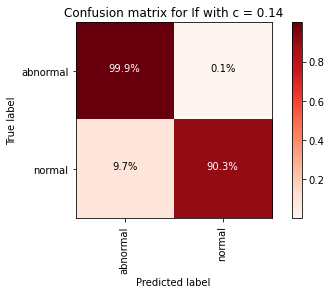

In [88]:
s = datetime.datetime.now()
y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c_max).fit(x_train).predict(x_test)
t = datetime.datetime.now() - s
cm_if = confusion_matrix(y_test, y_pred)
print(f"trained isolation forest in: {t}")
print(f"AUC: {roc_auc_score(y_test, y_pred):.1%}")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(cm_if, f"Confusion matrix for If with c = {c_max}")

## Cross validation for LOF 

In [3]:
def cross_validation_lof(contamination):
    highest_score = 0
    highest_score_c = 0
    #print("array:", contamination)
    for c in contamination:
        s = datetime.datetime.now()
        y_pred = LocalOutlierFactor(n_neighbors=100, metric='euclidean', algorithm = 'auto', contamination=c, n_jobs=-1).fit_predict(x_test)
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_test, y_pred)
        if p + r + a > highest_score: highest_score = p + r + a; highest_score_c = c
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        # fp through formula
        fp = tp / p - tp
        
        # predicted true
        positives = yp[np.where(yp == -1)]
        print(f"{len(positives)} ({tp}) -> fp = {len(positives) - tp}/{fp}")
        
        print(f"contamination: {c} \t tp: {tp}/{s} -> fp = {fp}")
        print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
        print("--------------------")
    return highest_score_c

In [4]:
contamination = [round(0.1 + 0.1*i, 2) for i in range(5)]
c_max = cross_validation_lof(contamination)
c_max

33707 (900) -> fp = 32807/32807.0
contamination: 0.1 	 tp: 900/16048 -> fp = 32807.0
AUC : 47.7% 	 precision: 0.0267 	 recall: 0.0561 	 f1: 0.03617726861621948
--------------------
67414 (1493) -> fp = 65921/65921.0
contamination: 0.2 	 tp: 1493/16048 -> fp = 65921.0
AUC : 44.4% 	 precision: 0.0221 	 recall: 0.093 	 f1: 0.03577676068150775
--------------------
101121 (2055) -> fp = 99066/99066.0
contamination: 0.3 	 tp: 2055/16048 -> fp = 99066.0
AUC : 41.0% 	 precision: 0.0203 	 recall: 0.128 	 f1: 0.03507753757393167
--------------------
134828 (2640) -> fp = 132188/132188.0
contamination: 0.4 	 tp: 2640/16048 -> fp = 132188.0
AUC : 37.6% 	 precision: 0.0196 	 recall: 0.165 	 f1: 0.034995625546806644
--------------------
168534 (3209) -> fp = 165325/165325.0
contamination: 0.5 	 tp: 3209/16048 -> fp = 165325.0
AUC : 34.2% 	 precision: 0.019 	 recall: 0.2 	 f1: 0.03477045432382356
--------------------


0.5

In [5]:
contamination = [round(0.01 + 0.01*i, 2) for i in range(10)]
c_max = cross_validation_lof(contamination)
c_max

3363 (162) -> fp = 3201/3201.0
contamination: 0.01 	 tp: 162/16048 -> fp = 3201.0
AUC : 50.0% 	 precision: 0.0482 	 recall: 0.0101 	 f1: 0.016691566637473596
--------------------
6742 (253) -> fp = 6489/6489.000000000001
contamination: 0.02 	 tp: 253/16048 -> fp = 6489.000000000001
AUC : 49.8% 	 precision: 0.0375 	 recall: 0.0158 	 f1: 0.022202720491443617
--------------------
10113 (428) -> fp = 9685/9685.0
contamination: 0.03 	 tp: 428/16048 -> fp = 9685.0
AUC : 49.8% 	 precision: 0.0423 	 recall: 0.0267 	 f1: 0.03272046175604908
--------------------
13483 (499) -> fp = 12984/12984.0
contamination: 0.04 	 tp: 499/16048 -> fp = 12984.0
AUC : 49.5% 	 precision: 0.037 	 recall: 0.0311 	 f1: 0.03379499508990552
--------------------
16854 (562) -> fp = 16292/16292.0
contamination: 0.05 	 tp: 562/16048 -> fp = 16292.0
AUC : 49.2% 	 precision: 0.0333 	 recall: 0.035 	 f1: 0.034162057017810464
--------------------
20225 (621) -> fp = 19604/19604.0
contamination: 0.06 	 tp: 621/16048 -> fp = 

0.03

In [6]:
c_max = 0.5

In [7]:
contamination = [round(c_max-0.01 + 0.001*i, 3) for i in range(1,10)]
c_max = cross_validation_lof(contamination)
c_max

165501 (3177) -> fp = 162324/162324.0
contamination: 0.491 	 tp: 3177/16048 -> fp = 162324.0
AUC : 34.6% 	 precision: 0.0192 	 recall: 0.198 	 f1: 0.034998815746713006
--------------------
165838 (3179) -> fp = 162659/162659.0
contamination: 0.492 	 tp: 3179/16048 -> fp = 162659.0
AUC : 34.6% 	 precision: 0.0192 	 recall: 0.198 	 f1: 0.03495596142638795
--------------------
166170 (3184) -> fp = 162986/162986.0
contamination: 0.493 	 tp: 3184/16048 -> fp = 162986.0
AUC : 34.5% 	 precision: 0.0192 	 recall: 0.198 	 f1: 0.03494715121447936
--------------------
166510 (3189) -> fp = 163321/163321.0
contamination: 0.494 	 tp: 3189/16048 -> fp = 163321.0
AUC : 34.5% 	 precision: 0.0192 	 recall: 0.199 	 f1: 0.03493684198994292
--------------------
166849 (3193) -> fp = 163656/163656.0
contamination: 0.495 	 tp: 3193/16048 -> fp = 163656.0
AUC : 34.5% 	 precision: 0.0191 	 recall: 0.199 	 f1: 0.03491582694084649
--------------------
167186 (3197) -> fp = 163989/163989.0
contamination: 0.496 

0.491

trainning LOF in 0:01:41.432512
              precision    recall  f1-score   support

     anomaly       0.02      0.20      0.03     16048
      normal       0.92      0.49      0.64    321021

    accuracy                           0.48    337069
   macro avg       0.47      0.35      0.34    337069
weighted avg       0.88      0.48      0.62    337069

AUC:  34.6%


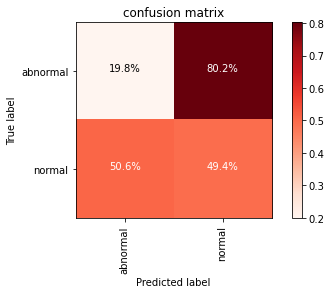

In [8]:
start = datetime.datetime.now()
y_pred = LocalOutlierFactor(n_neighbors=100, metric='euclidean', algorithm = 'auto', contamination=c_max, n_jobs=-1).fit_predict(x_test)
trainning_time = datetime.datetime.now() - start
print(f"trainning LOF in {trainning_time}")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "confusion matrix")
print(classification_report(y_test, y_pred, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_pred)))

# DBSCAN

Tested parameters: 
* eps

In [9]:
def cross_validation_dbscan(eps):
    highest_score = 0
    best_eps = 0
    for e in eps:
        s = datetime.datetime.now()
        db = DBSCAN(eps=e, min_samples=10, metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
        y_pred = [1 if i != -1 else i for i in db.labels_]
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_test, y_pred)
        if p + r + a > highest_score: highest_score = p + r + a; best_eps = e
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        print(tp)
        fp = len(prediction) - tp
        
        print(f"eps: {e} \t tp: {tp}/{s} -> fp = {fp}")
        print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
        print("--------------------")
    return best_eps

In [96]:
eps = [round(0.1 + 0.1*i, 2) for i in range(5)]
e_max = cross_validation_dbscan(eps)
e_max

4740
eps: 0.1 	 tp: 4740/16048 -> fp = 11308
AUC : 20.9% 	 precision: 0.0166 	 recall: 0.295 	 f1: 0.03134392017219319
--------------------
4723
eps: 0.2 	 tp: 4723/16048 -> fp = 11325
AUC : 21.0% 	 precision: 0.0165 	 recall: 0.294 	 f1: 0.03131412583332504
--------------------
4719
eps: 0.3 	 tp: 4719/16048 -> fp = 11329
AUC : 21.0% 	 precision: 0.0165 	 recall: 0.294 	 f1: 0.03131688184994575
--------------------
4719
eps: 0.4 	 tp: 4719/16048 -> fp = 11329
AUC : 21.0% 	 precision: 0.0166 	 recall: 0.294 	 f1: 0.031344755781244286
--------------------
4718
eps: 0.5 	 tp: 4718/16048 -> fp = 11330
AUC : 21.1% 	 precision: 0.0166 	 recall: 0.294 	 f1: 0.03136425883823275
--------------------


0.5

In [97]:
eps = [round(0.01 + 0.01*i, 2) for i in range(10)]
e_max = cross_validation_dbscan(eps)
e_max

4794
eps: 0.01 	 tp: 4794/16048 -> fp = 11254
AUC : 19.4% 	 precision: 0.0161 	 recall: 0.299 	 f1: 0.030634447458471915
--------------------
4777
eps: 0.02 	 tp: 4777/16048 -> fp = 11271
AUC : 20.1% 	 precision: 0.0163 	 recall: 0.298 	 f1: 0.03099522776009681
--------------------
4777
eps: 0.03 	 tp: 4777/16048 -> fp = 11271
AUC : 20.4% 	 precision: 0.0165 	 recall: 0.298 	 f1: 0.031207332449223572
--------------------
4767
eps: 0.04 	 tp: 4767/16048 -> fp = 11281
AUC : 20.6% 	 precision: 0.0165 	 recall: 0.297 	 f1: 0.03124272920018744
--------------------
4767
eps: 0.05 	 tp: 4767/16048 -> fp = 11281
AUC : 20.7% 	 precision: 0.0165 	 recall: 0.297 	 f1: 0.03133751429811067
--------------------
4757
eps: 0.06 	 tp: 4757/16048 -> fp = 11291
AUC : 20.8% 	 precision: 0.0165 	 recall: 0.296 	 f1: 0.031323048153342685
--------------------
4754
eps: 0.07 	 tp: 4754/16048 -> fp = 11294
AUC : 20.8% 	 precision: 0.0166 	 recall: 0.296 	 f1: 0.031349016633970224
--------------------
4753
eps:

0.08

In [10]:
e_max = 0.08

In [11]:
eps = [round(e_max-0.01 + 0.001*i, 3) for i in range(1,10)]
e_max = cross_validation_lof(contamination)
e_max

165501 (3177) -> fp = 162324/162324.0
contamination: 0.491 	 tp: 3177/16048 -> fp = 162324.0
AUC : 34.6% 	 precision: 0.0192 	 recall: 0.198 	 f1: 0.034998815746713006
--------------------
165838 (3179) -> fp = 162659/162659.0
contamination: 0.492 	 tp: 3179/16048 -> fp = 162659.0
AUC : 34.6% 	 precision: 0.0192 	 recall: 0.198 	 f1: 0.03495596142638795
--------------------
166170 (3184) -> fp = 162986/162986.0
contamination: 0.493 	 tp: 3184/16048 -> fp = 162986.0
AUC : 34.5% 	 precision: 0.0192 	 recall: 0.198 	 f1: 0.03494715121447936
--------------------
166510 (3189) -> fp = 163321/163321.0
contamination: 0.494 	 tp: 3189/16048 -> fp = 163321.0
AUC : 34.5% 	 precision: 0.0192 	 recall: 0.199 	 f1: 0.03493684198994292
--------------------
166849 (3193) -> fp = 163656/163656.0
contamination: 0.495 	 tp: 3193/16048 -> fp = 163656.0
AUC : 34.5% 	 precision: 0.0191 	 recall: 0.199 	 f1: 0.03491582694084649
--------------------
167186 (3197) -> fp = 163989/163989.0
contamination: 0.496 

0.491

trainning Isolation Forest in 0:00:43.428649
              precision    recall  f1-score   support

     anomaly       0.02      0.29      0.03     16048
      normal       0.78      0.13      0.22    321021

    accuracy                           0.14    337069
   macro avg       0.40      0.21      0.13    337069
weighted avg       0.75      0.14      0.21    337069

AUC:  21.1%


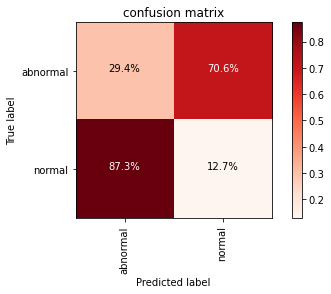

In [12]:
start = datetime.datetime.now()
db = DBSCAN(eps=e_max, min_samples=10, metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
y_pred = [1 if i != -1 else i for i in db.labels_]
trainning_time = datetime.datetime.now() - start
print(f"trainning Isolation Forest in {trainning_time}")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "confusion matrix")
print(classification_report(y_test, y_pred, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_pred)))